### trainvin the skil issue vision model vit

In [37]:
!pip install transformers torch torchvision 

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.7 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.3 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.2 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 2.9 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 13.2 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 8.1 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 89.4 MB/s eta 0:00:00:00:0100:01
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.8.93
    Uninstalling nvidia-nvjitlink-cu12-12.8.93:
      Successfully uninstalled nvidia-nvjitlink-cu12-12.8.93
  Attempting uninstall: nvidia-curand-cu12
    Found existing installation: nvidia-curand-cu12 10.3.9.90
    Uninstalling nvidia-curand-cu12-1

In [38]:
from transformers import ViTFeatureExtractor, ViTImageProcessor, ViTModel, ViTConfig
import torch.nn as nn
import torch.nn.functional as F

In [39]:
# Load model directly
from transformers import AutoImageProcessor, AutoModelForImageClassification

processor = AutoImageProcessor.from_pretrained("google/vit-base-patch16-224")
model = AutoModelForImageClassification.from_pretrained("google/vit-base-patch16-224")

preprocessor_config.json:   0%|          | 0.00/160 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/69.7k [00:00<?, ?B/s]

Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

In [3]:
import os
import PIL 

In [4]:
train_dir="/kaggle/input/skin-disease-dataset/skin-disease-datasaet/train_set"

In [5]:
os.listdir(train_dir) #the deseases we will be treating

['FU-nail-fungus',
 'FU-ringworm',
 'VI-shingles',
 'BA-impetigo',
 'FU-athlete-foot',
 'VI-chickenpox',
 'PA-cutaneous-larva-migrans',
 'BA- cellulitis']

In [43]:
import pathlib
data_dir=pathlib.Path(train_dir)
data_dir

PosixPath('/kaggle/input/skin-disease-dataset/skin-disease-datasaet/train_set')

In [44]:
cellulitis=list(data_dir.glob('BA- cellulitis/*'))
len(cellulitis)

136

In [45]:
FU_athlete_foot=list(data_dir.glob('FU-athlete-foot/*'))
len(FU_athlete_foot)

124

In [46]:
VI_chickenpoxt=list(data_dir.glob('VI-chickenpox/*'))
len(VI_chickenpoxt)

136

In [47]:
VI_shingles=list(data_dir.glob('VI-shingles/*'))
len(VI_shingles)


130

In [48]:
FU_nail_fungus=list(data_dir.glob('FU-nail-fungus/*'))
len(FU_nail_fungus)

129

In [49]:
BA_impetigo=list(data_dir.glob('BA-impetigo/*'))
len(BA_impetigo)

80

In [50]:
FU_ringworm=list(data_dir.glob('FU-ringworm/*'))
len(FU_ringworm)

90

In [51]:
PA_cutaneous_larva_migrans=list(data_dir.glob('PA-cutaneous-larva-migrans/*'))
len(PA_cutaneous_larva_migrans)

100

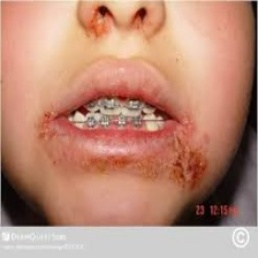

In [52]:
#exp of the infections we are working with 
PIL.Image.open(str(BA_impetigo[16]))

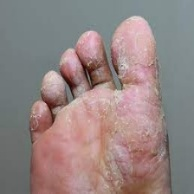

In [53]:
PIL.Image.open(str(FU_athlete_foot[16]))

In [54]:
disease_images_train_dic={
    'cellulitis':list(data_dir.glob('BA- cellulitis/*')),
    'impetigo':list(data_dir.glob('BA-impetigo/*')),
    'athlete-foot':list(data_dir.glob('FU-athlete-foot/*')),
    'nail-fungus':list(data_dir.glob('FU-nail-fungus/*')),
    'ringworm':list(data_dir.glob('FU-ringworm/*')),
    'cutaneous-larva-migrans':list(data_dir.glob('PA-cutaneous-larva-migrans/*')),
    'chickenpox':list(data_dir.glob('VI-chickenpox/*')),
    'shingles':list(data_dir.glob('VI-shingles/*')),
#     'normal':list(data_dir.glob('normal/*')),   
}

In [55]:
len(disease_images_train_dic)

8

In [56]:
disease_train_label_dic={
    'cellulitis': 0,
    'impetigo': 1,
    'athlete-foot': 2,
    'nail-fungus': 3,
    'ringworm': 4,
    'cutaneous-larva-migrans':5,
    'chickenpox':6,
    'shingles':7,
#     'normal':8,
}

In [57]:
import cv2
from PIL import Image
from torchvision import transforms
from transformers import ViTImageProcessor
x_train = []
y_train = []

# Define the image transformation
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=processor.image_mean, std=processor.image_std)
])

for image_name, image_paths in disease_images_train_dic.items():
    for image_path in image_paths:
        img = cv2.imread(str(image_path))
        if img is None:
            continue

        
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

      
        img_pil = Image.fromarray(img_rgb)

        
        img_transformed = transform(img_pil)

        x_train.append(img_transformed)
        y_train.append(disease_train_label_dic[image_name])

In [58]:
#x_train = torch.stack(x_train)
#y_train = torch.tensor(y_train)

In [59]:
x_train[0].shape

torch.Size([3, 224, 224])

In [9]:
# Define the image transformation
from transformers import AutoImageProcessor, AutoModelForImageClassification

processor = AutoImageProcessor.from_pretrained("google/vit-base-patch16-224")
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=processor.image_mean, std=processor.image_std)
])

Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.


In [10]:
from torchvision import datasets, transforms
from torch.utils.data import Dataset, DataLoader
train_dataset = datasets.ImageFolder(root=train_dir, transform=transform)


In [11]:
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)


In [12]:
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [13]:
from transformers import ViTForImageClassification

model = ViTForImageClassification.from_pretrained(
    "google/vit-base-patch16-224-in21k",
    num_labels=8  # we have 8 diseases
)

model.to(device)  


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ViTForImageClassification(
  (vit): ViTModel(
    (embeddings): ViTEmbeddings(
      (patch_embeddings): ViTPatchEmbeddings(
        (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): ViTEncoder(
      (layer): ModuleList(
        (0-11): 12 x ViTLayer(
          (attention): ViTAttention(
            (attention): ViTSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
            )
            (output): ViTSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): ViTIntermediate(
            (dense): Linear(in_features=768, out_features=3072, bias=True)
            (intermed

In [14]:
import torch.nn as nn

loss_fn = nn.CrossEntropyLoss()
import torch.optim as optim

optimizer = optim.Adam(model.parameters(), lr=5e-5) 
num_epochs = 5  #10 is maybe overkill ?


In [15]:
for epoch in range(num_epochs):
    model.train()
    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)
        logits = outputs.logits
        loss = loss_fn(logits, labels)

        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {loss.item():.4f}")

Epoch 1/5, Loss: 1.0452
Epoch 2/5, Loss: 0.4574
Epoch 3/5, Loss: 0.2712
Epoch 4/5, Loss: 0.1792
Epoch 5/5, Loss: 0.1482


In [20]:
#val data 
test_dir="/kaggle/input/skin-disease-dataset/skin-disease-datasaet/test_set"
test_dataset = datasets.ImageFolder(root=test_dir, transform=transform)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=True)


In [21]:
model.eval()
correct = 0
total = 0
val_loss = 0

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)
        logits = outputs.logits
        loss = loss_fn(logits, labels)

        val_loss += loss.item()
        _, predicted = torch.max(logits, dim=1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

accuracy = correct / total
avg_loss = val_loss / len(test_loader)

print(f"Validation Accuracy: {accuracy:.4f}, Validation Loss: {avg_loss:.4f}")


Validation Accuracy: 0.9744, Validation Loss: 0.2126


In [22]:
torch.save(model.state_dict(), "vit_infection.pth")

In [26]:
testytestim="/kaggle/input/skin-disease-dataset/skin-disease-datasaet/test_set/BA- cellulitis/BA- cellulitis (139).jpg"
from PIL import Image
# Load your image
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

img = Image.open(testytestim).convert("RGB")

# Preprocess image using processor
inputs = processor(images=img, return_tensors="pt").to(device)
with torch.no_grad():
    outputs = model(**inputs)
    logits = outputs.logits
    predicted_class_idx = logits.argmax(-1).item()

print("Predicted class ID:", predicted_class_idx)
print("Predicted label:", model.config.id2label[predicted_class_idx])



Predicted class ID: 0
Predicted label: LABEL_0


In [ ]:
#to use this bad boy later
"""

from transformers import ViTForImageClassification

model = ViTForImageClassification.from_pretrained("google/vit-base-patch16-224", num_labels=8)
model.load_state_dict(torch.load("vit_model.pth"))
model.to(device)
model.eval()

"""